In [1]:
import numpy as np
import pandas as pd
#from fbprophet import Prophet
#import pystan
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
from keras.layers import Bidirectional
from keras.layers import TimeDistributed

In [4]:
n_timesteps = 10

In [3]:
data = pd.read_csv('all_features.csv')

In [4]:
# One Hot Encoding
y = data['purchase']
y = pd.get_dummies(y).values
y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [5]:
y.shape

(10157290, 2)

In [8]:
selected = data.loc[:,['event_type', 'Sales', '# Sessions', 'InteractionTime','max_price', 'min_price','# Cart',
       '# View', '# Remove', 'insession_cart','purchase']]

# SMOTE

In [20]:
data = data.fillna(0)

In [10]:
import imblearn

In [11]:
print(imblearn.__version__)

0.7.0


In [4]:
from imblearn.over_sampling import SMOTE

In [15]:
import collections
counter = collections.Counter(data['purchase'].values)

In [16]:
print(counter)

Counter({False: 8931518, True: 1225772})


In [21]:
#SMOTE
oversample = SMOTE()
data,label=oversample.fit_sample(data.iloc[:,:-1],data.iloc[:,-1])

In [22]:
counter2 = collections.Counter(label)

In [23]:
print(counter2)

Counter({False: 8931518, True: 8931518})


In [25]:
data.to_csv('smotedata.csv')

In [26]:
label.to_csv('smotelabel.csv')

In [21]:
values = data.values

In [22]:
values.shape

(10157290, 10)

# Balancing Data

In [18]:
# Conversion Rate
134427/10157290

0.013234534014486148

In [29]:
purchase = selected[selected['purchase']==True]
# 1225772 records in total

In [ ]:
1225772/(1225772+1500000)

In [31]:
not_purchase.shape

(8931518, 11)

In [30]:
not_purchase = selected[selected['purchase']==False]

In [32]:
# dropping most of the False records, keep the purchase around half
not_purchase = not_purchase.sample(n = 1500000)

In [33]:
df = purchase.append(not_purchase)

In [37]:
df.to_csv('samplingdata.csv')

# Train Test Split

In [34]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1]

In [35]:
y = pd.get_dummies(y).values
y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.15)


In [37]:
X_test,y_test

(array([[ 2.  , 11.  ,  1.  , ...,  0.  ,  0.  , 62.  ],
        [ 1.  , 14.75,  1.  , ...,  1.  ,  0.  , 23.  ],
        [ 3.  , 36.25,  2.  , ...,  1.  ,  0.  ,  6.  ],
        ...,
        [ 4.  ,  2.25,  2.  , ...,  1.  ,  2.  , 28.  ],
        [ 2.  ,  4.5 ,  1.  , ...,  1.  ,  0.  ,  2.  ],
        [ 1.  , 18.  ,  1.  , ...,  1.  ,  0.  ,  0.  ]]),
 array([[0, 1],
        [1, 0],
        [0, 1],
        ...,
        [1, 0],
        [0, 1],
        [1, 0]], dtype=uint8))

In [38]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2316906, 1, 10) (2316906, 2) (408866, 1, 10) (408866, 2)


# Parameter Tuning using GridSearchCV

Try different batch_sizes and epochs

### skip this cell first

In [25]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
MODEL = KerasClassifier(build_fn = c_model)

batch_sizes = [50, 100, 200, 500, 1000, 2000]
epochs = [5,10,50]
parameters = {'batch_size': batch_sizes, 'epochs': epochs}
clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

NameError: name 'model' is not defined

### Start here

Tune optimizer

In [41]:
def c_model(optimizer):
    model = Sequential()
    model.add(Bidirectional(LSTM(40, return_sequences=True), input_shape=(1,10)))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(5, activation='tanh'))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())

    model.add(Dense(2, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])
    return model

In [ ]:
model = KerasClassifier(build_fn=c_model, epochs = 20, batch_size = 100)
parameters = {'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']}
clf = GridSearchCV(model, parameters,cv = 5)
grid_result = clf.fit(X_train,y_train)

Epoch 1/20
1853524/1853524 [==============================] - 42s 22us/step - loss: nan - accuracy: 0.5503
Epoch 2/20
1853524/1853524 [==============================] - 41s 22us/step - loss: nan - accuracy: 0.5503
Epoch 3/20
1853524/1853524 [==============================] - 40s 22us/step - loss: nan - accuracy: 0.5503
Epoch 4/20
1853524/1853524 [==============================] - 40s 22us/step - loss: nan - accuracy: 0.5503 0s - loss: nan - accuracy: 0
Epoch 5/20
1853524/1853524 [==============================] - 40s 22us/step - loss: nan - accuracy: 0.5503
Epoch 6/20
1853524/1853524 [==============================] - 40s 22us/step - loss: nan - accuracy: 0.5503
Epoch 7/20
1853524/1853524 [==============================] - 40s 22us/step - loss: nan - accuracy: 0.5503
Epoch 8/20
1853524/1853524 [==============================] - 41s 22us/step - loss: nan - accuracy: 0.5503 4s - loss: - ETA: 0s - loss: nan  - ETA: 0s - loss: nan - accuracy: 0.55
Epoch 9/20
1853524/1853524 [==============

1853525/1853525 [==============================] - 39s 21us/step - loss: nan - accuracy: 0.5501
Epoch 5/20
1853525/1853525 [==============================] - 39s 21us/step - loss: nan - accuracy: 0.5501
Epoch 6/20
1853525/1853525 [==============================] - 39s 21us/step - loss: nan - accuracy: 0.5501 1s - ETA: 0s - loss: nan - accuracy: 0.55
Epoch 7/20
1853525/1853525 [==============================] - 39s 21us/step - loss: nan - accuracy: 0.5501 1s 
Epoch 8/20
1853525/1853525 [==============================] - 39s 21us/step - loss: nan - accuracy: 0.5501
Epoch 9/20
1853525/1853525 [==============================] - 40s 21us/step - loss: nan - accuracy: 0.5501
Epoch 10/20
1853525/1853525 [==============================] - 39s 21us/step - loss: nan - accuracy: 0.5501
Epoch 11/20
1853525/1853525 [==============================] - 39s 21us/step - loss: nan - accuracy: 0.5501 2s - loss: nan - a 
Epoch 12/20
1853525/1853525 [==============================] - 39s 21us/step - loss: na

1853525/1853525 [==============================] - 42s 23us/step - loss: nan - accuracy: 0.5504 0s - loss: nan - accurac
Epoch 5/20
1853525/1853525 [==============================] - 42s 23us/step - loss: nan - accuracy: 0.5504 0s - loss: nan -
Epoch 6/20
1853525/1853525 [==============================] - 42s 22us/step - loss: nan - accuracy: 0.5504 1s - loss: nan - accuracy: 0. - ETA: 1s - loss
Epoch 7/20
1853525/1853525 [==============================] - 42s 22us/step - loss: nan - accuracy: 0.5504 0s - loss: nan - accuracy: 0.550 - ETA: 0s - loss: nan - accuracy:  - ETA: 0s - loss: nan - accuracy: 0.55 - ETA: 0s - loss: nan - accuracy: 0.55
Epoch 8/20
1853525/1853525 [==============================] - 42s 22us/step - loss: nan - accuracy: 0.5504 5s - loss - ETA: 4s - ETA: 2s - loss: nan - accu - ETA: 2s - loss: nan - accuracy: 0.5 
Epoch 9/20
1853525/1853525 [==============================] - 42s 23us/step - loss: nan - accuracy: 0.5504
Epoch 10/20
1853525/1853525 [=================

1853525/1853525 [==============================] - 41s 22us/step - loss: nan - accuracy: 0.5502
Epoch 8/20
1853525/1853525 [==============================] - 41s 22us/step - loss: nan - accuracy: 0.5502 0s - loss: nan - acc
Epoch 9/20
1853525/1853525 [==============================] - 41s 22us/step - loss: nan - accuracy: 0.5502
Epoch 10/20
1853525/1853525 [==============================] - 41s 22us/step - loss: nan - accuracy: 0.5502
Epoch 11/20
1853525/1853525 [==============================] - 42s 23us/step - loss: nan - accuracy: 0.5502
Epoch 12/20
1853525/1853525 [==============================] - 41s 22us/step - loss: nan - accuracy: 0.5502 6s - loss: nan - accuracy: 0.550 - ETA: 6s - loss: nan - accuracy:  - ETA: 6s  - ETA: 4s - loss: nan - accur - 
Epoch 13/20
1853525/1853525 [==============================] - 41s 22us/step - loss: nan - accuracy: 0.5502 7s - loss: nan - accuracy:  - ETA: 6s - loss - ETA: 5s - loss:  - ETA: 2s - loss: nan - accuracy: 0 - ETA: 2 - ETA: 0s - loss

1853525/1853525 [==============================] - 38s 21us/step - loss: nan - accuracy: 0.5504 0s - loss: nan - accuracy: 0.
Epoch 9/20
1853525/1853525 [==============================] - 39s 21us/step - loss: nan - accuracy: 0.5504
Epoch 10/20
1853525/1853525 [==============================] - 39s 21us/step - loss: nan - accuracy: 0.5504
Epoch 11/20
1853525/1853525 [==============================] - 38s 21us/step - loss: nan - accuracy: 0.5504
Epoch 12/20
1853525/1853525 [==============================] - 38s 21us/step - loss: nan - accuracy: 0.5504
Epoch 13/20
1853525/1853525 [==============================] - 38s 21us/step - loss: nan - accuracy: 0.5504A: 3s - los
Epoch 14/20
1853525/1853525 [==============================] - 38s 21us/step - loss: nan - accuracy: 0.5504
Epoch 15/20
1853525/1853525 [==============================] - 38s 21us/step - loss: nan - accuracy: 0.5504 1s - 
Epoch 16/20
1853525/1853525 [==============================] - 38s 21us/step - loss: nan - accuracy: 0

1853524/1853524 [==============================] - 46s 25us/step - loss: nan - accuracy: 0.5503
Epoch 6/20
1853524/1853524 [==============================] - 46s 25us/step - loss: nan - accuracy: 0.5503
Epoch 7/20
1853524/1853524 [==============================] - 46s 25us/step - loss: nan - accuracy: 0.5503
Epoch 8/20
1853524/1853524 [==============================] - 46s 25us/step - loss: nan - accuracy: 0.5503
Epoch 9/20
1853524/1853524 [==============================] - 47s 25us/step - loss: nan - accuracy: 0.5503 1s - loss: nan - accura - ETA: 0s - loss: nan - accuracy: - ETA: 0s - loss: nan - accura
Epoch 10/20
1853524/1853524 [==============================] - 45s 24us/step - loss: nan - accuracy: 0.5503
Epoch 11/20
1853524/1853524 [==============================] - 45s 24us/step - loss: nan - accuracy: 0.5503
Epoch 12/20
1853524/1853524 [==============================] - 45s 25us/step - loss: nan - accuracy: 0.5503
Epoch 13/20
1853524/1853524 [==============================] - 

1853525/1853525 [==============================] - 43s 23us/step - loss: nan - accuracy: 0.5501
Epoch 10/20
1853525/1853525 [==============================] - 43s 23us/step - loss: nan - accuracy: 0.5501
Epoch 11/20
1853525/1853525 [==============================] - 46s 25us/step - loss: nan - accuracy: 0.5501 0s - loss: nan - accuracy: 0.5
Epoch 12/20
1853525/1853525 [==============================] - 44s 24us/step - loss: nan - accuracy: 0.5501 1
Epoch 13/20
1853525/1853525 [==============================] - 44s 24us/step - loss: nan - accuracy: 0.5501 0s - loss: nan - a
Epoch 14/20
1853525/1853525 [==============================] - 43s 23us/step - loss: nan - accuracy: 0.5501
Epoch 15/20
1853525/1853525 [==============================] - 44s 24us/step - loss: nan - accuracy: 0.5501
Epoch 16/20
1853525/1853525 [==============================] - 43s 23us/step - loss: nan - accuracy: 0.5501
Epoch 17/20
1853525/1853525 [==============================] - 43s 23us/step - loss: nan - accur

1853525/1853525 [==============================] - 43s 23us/step - loss: nan - accuracy: 0.5504
Epoch 14/20
1853525/1853525 [==============================] - 50s 27us/step - loss: nan - accuracy: 0.5504
Epoch 15/20
1853525/1853525 [==============================] - 47s 26us/step - loss: nan - accuracy: 0.5504
Epoch 16/20
1853525/1853525 [==============================] - 46s 25us/step - loss: nan - accuracy: 0.5504
Epoch 17/20
1853525/1853525 [==============================] - 45s 24us/step - loss: nan - accuracy: 0.5504
Epoch 18/20
1853525/1853525 [==============================] - 45s 24us/step - loss: nan - accuracy: 0.5504
Epoch 19/20
1853525/1853525 [==============================] - 45s 24us/step - loss: nan - accuracy: 0.5504
Epoch 20/20
463381/463381 [==============================] - 4s 9us/step
Epoch 1/20
1853525/1853525 [==============================] - 47s 25us/step - loss: nan - accuracy: 0.5587
Epoch 2/20
1853525/1853525 [==============================] - 46s 25us/step 

1853525/1853525 [==============================] - 48s 26us/step - loss: nan - accuracy: 0.5502
Epoch 19/20
1853525/1853525 [==============================] - 50s 27us/step - loss: nan - accuracy: 0.5502
Epoch 20/20
463381/463381 [==============================] - 5s 10us/step
Epoch 1/20
1853524/1853524 [==============================] - 49s 26us/step - loss: nan - accuracy: 0.5516
Epoch 2/20
1853524/1853524 [==============================] - 49s 26us/step - loss: nan - accuracy: 0.5503 10s - lo - ETA: 10s - 
Epoch 3/20
1853524/1853524 [==============================] - 47s 25us/step - loss: nan - accuracy: 0.5503 1s - loss: 
Epoch 4/20
1853524/1853524 [==============================] - 46s 25us/step - loss: nan - accuracy: 0.5503
Epoch 5/20
1853524/1853524 [==============================] - 58s 31us/step - loss: nan - accuracy: 0.5503 10s - loss: nan  - ETA: 9s - 
Epoch 6/20
1853524/1853524 [==============================] - 57s 31us/step - loss: nan - accuracy: 0.5503 5s - loss: nan 

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
Running this example produces the following output.

### Could stop here, let's just get the summarize of the optimizer tuning for this step

In [25]:
 # define 10-fold cross validation test harness
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
  # create model
    model = Sequential()
    model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(1,9)))
    model.add(Dense(12, activation='relu'))
	model.add(Dense(8, activation='relu'))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())

    model.add(Dense(2, activation='softmax'))
	# Compile model
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
	# Fit the model
	model.fit(X[train], Y[train], epochs=10, batch_size=100, verbose=0)
	# evaluate the model
	scores = model.evaluate(X[test], Y[test], verbose=0)
	print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
	cvscores.append(scores[1] * 100)#try different hyperparameters

Train on 8000000 samples, validate on 1000000 samples
Epoch 1/10
 - 138s - loss: 0.3698 - accuracy: 0.8743 - val_loss: 0.3431 - val_accuracy: 0.8928
Epoch 2/10
 - 116s - loss: 0.3716 - accuracy: 0.8744 - val_loss: 0.3413 - val_accuracy: 0.8928
Epoch 3/10
 - 115s - loss: 0.3726 - accuracy: 0.8744 - val_loss: 0.3406 - val_accuracy: 0.8928
Epoch 4/10
 - 115s - loss: 0.3734 - accuracy: 0.8744 - val_loss: 0.3406 - val_accuracy: 0.8928
Epoch 5/10
 - 115s - loss: 0.3740 - accuracy: 0.8744 - val_loss: 0.3409 - val_accuracy: 0.8928
Epoch 6/10
 - 115s - loss: 0.3745 - accuracy: 0.8744 - val_loss: 0.3412 - val_accuracy: 0.8928
Epoch 7/10
 - 115s - loss: 0.3749 - accuracy: 0.8744 - val_loss: 0.3414 - val_accuracy: 0.8928
Epoch 8/10
 - 115s - loss: 0.3752 - accuracy: 0.8744 - val_loss: 0.3415 - val_accuracy: 0.8928
Epoch 9/10
 - 115s - loss: 0.3754 - accuracy: 0.8744 - val_loss: 0.3416 - val_accuracy: 0.8928
Epoch 10/10
 - 115s - loss: 0.3756 - accuracy: 0.8744 - val_loss: 0.3417 - val_accuracy: 0.

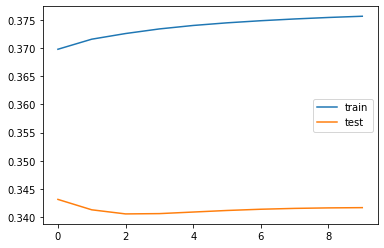

In [27]:
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [32]:
test_scores = model.evaluate(x_test,y_test)

1157290/1157290 [==============================] - 17s 15us/step


In [33]:
test_scores

[0.3245619818357451, 0.9015389680862427]